In [1]:
# Import Necessary Packages
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import os
import sys
sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
#from plotting_functions import *
#from utils import *

import altair as alt
from vega_datasets import data
# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

pd.set_option("display.max_colwidth", 200)

In [2]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})
sms_df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [3]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


In [5]:
# Code adapted from class demos and lab 2 provided function
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.4f (+/- %0.4f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [6]:
results_dict = {}
pipe_svc = make_pipeline(CountVectorizer(binary=True), SVC())
results_dict["SVC"] = mean_std_cross_val_scores(
    pipe_svc, X_train, y_train, return_train_score=True
)

In [7]:
pd.DataFrame(results_dict)

,SVC
fit_time,0.3752 (+/- 0.0112)
score_time,0.0890 (+/- 0.0018)
test_score,0.9791 (+/- 0.0043)
train_score,0.9960 (+/- 0.0005)


In [11]:
pipe_nb = make_pipeline(CountVectorizer(binary=True), BernoulliNB(alpha = 1.0)) # alpha for smoothing, default is 1.0
results_dict["Naive Bayes"] = mean_std_cross_val_scores(
    pipe_nb, X_train, y_train, return_train_score=True
)

In [12]:
pd.DataFrame(results_dict)

# The validation scores are very similar.
# Much faster than the SVC classifier!!

,SVC,Naive Bayes
fit_time,0.3752 (+/- 0.0112),0.0255 (+/- 0.0038)
score_time,0.0890 (+/- 0.0018),0.0050 (+/- 0.0005)
test_score,0.9791 (+/- 0.0043),0.9737 (+/- 0.0039)
train_score,0.9960 (+/- 0.0005),0.9869 (+/- 0.0006)


# Naive Bayes Hyperparameter: alpha

- High alpha -> underfitting: means we are adding large counts to everything and so we are diluting the data
- Low alpha -> overfitting

In [13]:
results_dict = {
    "alpha": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"bernoullinb__alpha": 10.0 ** np.arange(-7, 3)}

pipe_nb = make_pipeline(CountVectorizer(binary=True), BernoulliNB())
search = GridSearchCV(pipe_nb, param_grid, n_jobs=-1, return_train_score=True)
search.fit(X_train, y_train);

In [14]:
test_scores = search.cv_results_["mean_test_score"]
train_scores = search.cv_results_["mean_train_score"]
alpha_vals = param_grid["bernoullinb__alpha"]

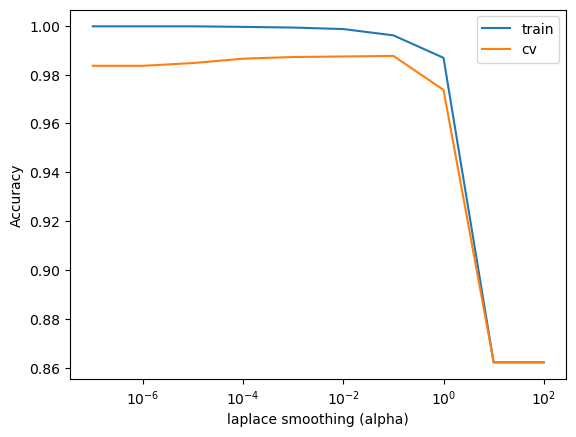

In [15]:
plt.semilogx(alpha_vals, train_scores, label="train")
plt.semilogx(alpha_vals, test_scores, label="cv")
plt.legend()
plt.xlabel("laplace smoothing (alpha)")
plt.ylabel("Accuracy");

# Naive Bayes with Continuous Features